<center><a href="https://www.nvidia.com/dli"> <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2020/03/DLI_Feature_new.png" alt="Header" style="width: 400px;"/> </a></center>

# 3. Convolutional Neural Networks

In the previous section, we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

## 3.1 Objectives

* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance

In [ ]:
!pip install -q triton

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import torch._dynamo
torch._dynamo.config.suppress_errors = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

## 3.2 Loading and Preparing the Data

### 3.2.1 Preparing Images

Let's begin by loading our DataFrames like we did in the previous lab:

In [ ]:
!gdown 1UAbN8FBfJsQLeEx8uJcEEeS7SJf_mlab
!gdown 1t7-vjrVdgMIxf_ATC5i7kfWHPbPhnaa8

In [ ]:
!unzip asl_image.zip
!unzip asl_data.zip

In [ ]:
train_df = pd.read_csv("sign_mnist_train.csv")
valid_df = pd.read_csv("sign_mnist_valid.csv")

This ASL data is already flattened.

In [ ]:
sample_df = train_df.head().copy()  # Grab the top 5 rows
sample_df.pop('label')
sample_x = sample_df.values
sample_x

In [ ]:
sample_x.shape

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(5, 784)` to `(5, 1, 28, 28)`. With [NumPy](https://numpy.org/doc/stable/index.html) arrays, we can pass a `-1` for any dimension we wish to remain the same.

In [ ]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1

sample_x = sample_x.reshape(-1, IMG_CHS, IMG_HEIGHT, IMG_WIDTH)
sample_x.shape

### 3.2.2 Create a Dataset

Let's add the steps above into our `MyDataset` class.

#### Exercise

There are 4 `FIXME`s in the class definition below. Can you replace them with the correct values?

In [ ]:
class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()  # Some operations below are in-place
        y_df = x_df.pop(FIXME)
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, FIXME, FIXME, FIXME)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

### 3.2.3 Create a DataLoader

Next, let's create the DataLoader from the Dataset

#### Exercise

One of these function calls is missing the `shuffle=True` argument. Can you remember which one it is and add it back in?

In [ ]:
BATCH_SIZE = 32

train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

Let's grab a batch from the DataLoader to make sure it works.

In [ ]:
batch = next(iter(train_loader))
batch

It looks different, but let's check the `shape`s to be sure.

In [ ]:
batch[0].shape

In [ ]:
batch[1].shape

## 3.3 Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

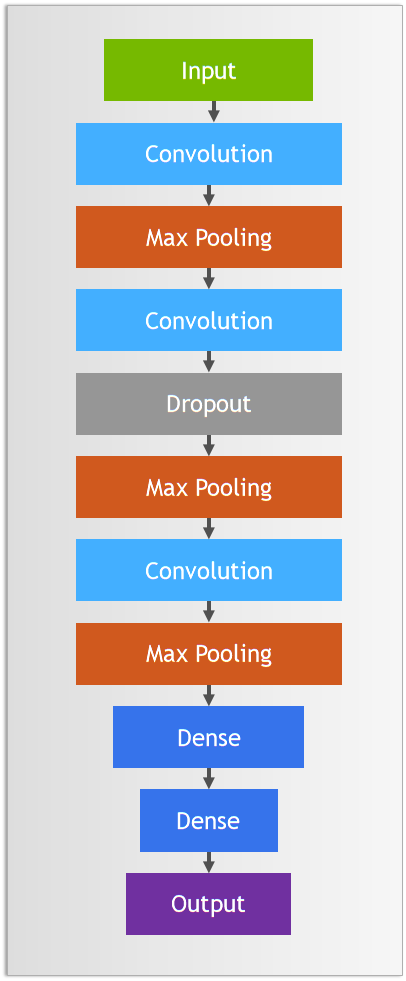

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [Stack Overflow](https://stackoverflow.com/)).

In [ ]:
n_classes = 24
kernel_size = 3
flattened_img_size = 75 * 3 * 3

model = nn.Sequential(
    # First convolution
    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3
    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, n_classes)
)

### 3.3.1 [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

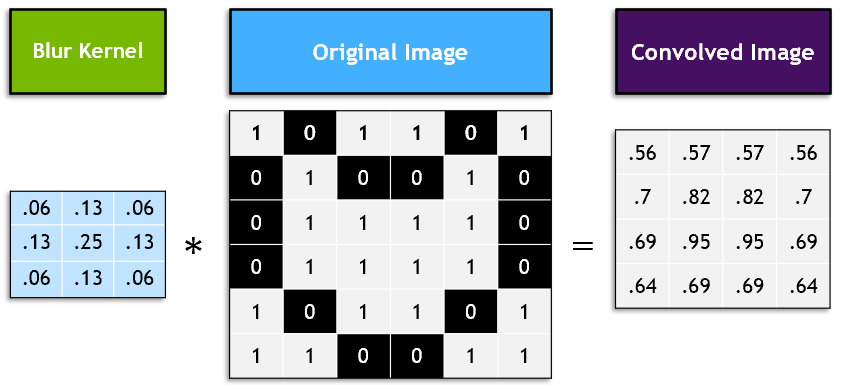

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1)
```
25 refers to the number of filters that will be learned. Even though `kernel_size = 3`, PyTorch will assume we want 3 x 3 filters. Stride refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

### 3.3.2 [BatchNormalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

There is a debate on best where to put the batch normalization layer. [This Stack Overflow post](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) compiles many perspectives.

### 3.3.3 [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

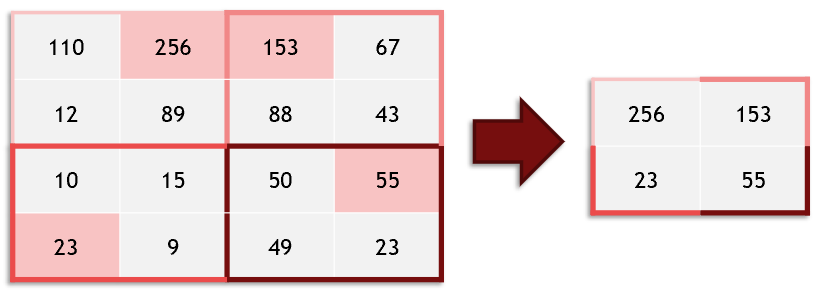

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### 3.3.4 [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

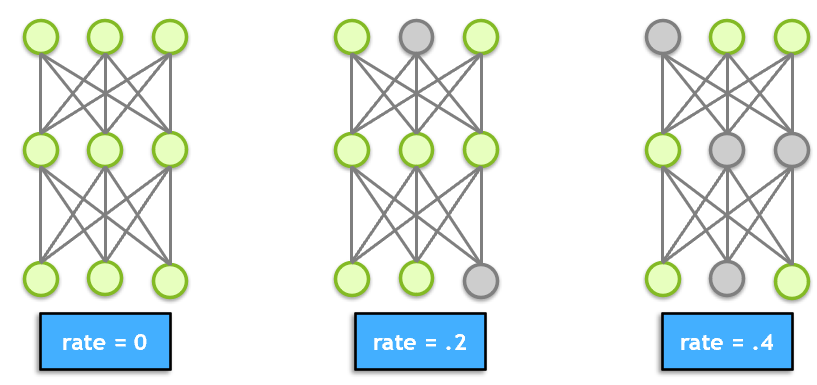

Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### 3.3.5 [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### 3.3.6 [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

We have seen dense linear layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## 3.4 Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

In [ ]:
model = torch.compile(model.to(device))
model

Since the problem we are trying to solve is still the same (classifying ASL images), we will continue to use the same `loss_function` and `accuracy` metric.

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [ ]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### 3.5 Training the Model

Despite the very different model architecture, the training looks exactly the same.

#### Exercise

These are the same `train` and `validate` functions as before, but they have been mixed up. Can you correctly name each function and replace the `FIXME`s?

One of them should have `model.train` and the other should have `model.eval`.

In [ ]:
def FIXME():
    loss = 0
    accuracy = 0

    model.FIXME()
    with torch.no_grad():
        for x, y in FIXME:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('FIXME - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
def FIXME():
    loss = 0
    accuracy = 0

    model.FIXME()
    for x, y in FIXME:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('FIXME - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

### 3.5.1 Discussion of Results

It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do. Let's talk about it in the next lecture.

## 3.6 Summary

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.

### 3.6.1 Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory. This is required to move on to the next notebook.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### 3.6.2 Next

In the last several sections you have focused on the creation and training of models. In order to further improve performance, you will now turn your attention to *data augmentation*, a collection of techniques that will allow your models to train on more and better data than what you might have originally at your disposal.

<center><a href="https://www.nvidia.com/dli"> <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2020/03/DLI_Feature_new.png" alt="Header" style="width: 400px;"/> </a></center>